<a href="https://colab.research.google.com/github/RaoSiddhant/SIT796_RL/blob/main/Task_7_2_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
#FOR SEMI-GRADIENT SARSA(0) and SARSA(LAMBDA) WITH LINEAR FUNCTION APPROXIMATION 
#Importing Relevant Packages for the Environment Setup
#This is th same environment we set up for Task 1.1 and 1.2
#We have a university campus map, states, actions taken by bus defined here
#and we use this later to show Value Iteration on this scoped environment 
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np

CAMPUS_MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]

class Univ_Camp_Bus(discrete.DiscreteEnv):
    
    def __init__(self):
        self.desc = np.asarray(CAMPUS_MAP, dtype='c')

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside bus
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # default reward when there is no pickup/dropoff
                            done = False
                            bus_loc = (row, col)

                            if action == 0:
                                new_row = min(row + 1, max_row)
                            elif action == 1:
                                new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and bus_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # batch of students not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (bus_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (bus_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(bus_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, bus_row, bus_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = bus_row
        i *= 5
        i += bus_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def np_random(seed=None):
      if seed is not None and not (isinstance(seed, int) and 0 <= seed):
        raise error.Error('Seed must be a non-negative integer or omitted, not {}'.format(seed))

      seed = create_seed(seed)

      rng = np.random.RandomState()
      rng.seed(_int_list_from_bigint(hash_seed(seed)))
      return rng, seed

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        bus_row, bus_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + bus_row][2 * bus_col + 1] = utils.colorize(
                out[1 + bus_row][2 * bus_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # Batch of students in bus
            out[1 + bus_row][2 * bus_col + 1] = utils.colorize(
                ul(out[1 + bus_row][2 * bus_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()


  


In [27]:
#Importing further relevant packages 

%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
import timeit
from collections import namedtuple
import os
import glob

#from lib.tile_coding import IHT, tiles
from matplotlib import pyplot as plt
from matplotlib import cm
matplotlib.style.use('ggplot')

import io
import base64
from IPython.display import HTML
from math import floor

# We do tiling here for our case here. In our case, the state action feature is [Bus Position and Action]
# Tile coding starts
class IHT:
    "Structure to handle collisions"
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles
# Tile coding ends

In [36]:
#We call our environment here and assign it to 'env' for us to use it later 
env = Univ_Camp_Bus()
# print('Number of States for our Environment are:',env.observation_space.n)
# print('Number of Actions for our Environment are:',env.action_space.n)
np.random.seed(5)


In [29]:
#We create this class for Linear Function Approximation for Sarsa(lambda) case to get action-value(q-value)
#The approximate value function in linear case becomes the summation of weights
#The predict, update and reset functions are used later
class QEstimator():

    
    def __init__(self, step_size, num_tilings=8, max_size=4096, tiling_dim=None, trace=False):
        
        self.trace = trace
        self.max_size = max_size
        self.num_tilings = num_tilings
        self.tiling_dim = tiling_dim or num_tilings

        # Step size is interpreted as the fraction of the way we want 
        # to move towards the target. To compute the learning rate alpha,
        # scale by number of tilings. 
        self.alpha = step_size / num_tilings

        # Initialize index hash table (IHT) for tile coding.
        self.iht = IHT(max_size)

        # Initialize weights (and optional trace)
        self.weights = np.zeros(max_size)
        if self.trace:
            self.z = np.zeros(max_size)



    #In our case, the state action feature is [Bus Position and Action]        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a 
        state-action pair.
        """
        featurized = tiles(self.iht, self.num_tilings, 
                           [np.array(state)], 
                           [action])
        
        
        
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value(s) using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for 
                        i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    def update(self, s, a, target):
        """
        Updates the estimator parameters
        for a given state and action towards
        the target using the gradient update rule 
        (and the eligibility trace if one has been set).
        """
        features = self.featurize_state_action(s, a)
        estimation = np.sum(self.weights[features])  # Linear FA
        delta = (target - estimation)
        
        if self.trace:
            # self.z[features] += 1  # Accumulating trace
            self.z[features] = 1  # Replacing trace
            self.weights += self.alpha * delta * self.z
        else:
            self.weights[features] += self.alpha * delta
                
    
    def reset(self, z_only=False):
        """
        Resets the eligibility trace (must be done at 
        the start of every epoch) and optionally the
        weight vector (if we want to restart training
        from scratch).
        """
        
        if z_only:
            assert self.trace, 'q-value estimator has no z to reset.'
            self.z = np.zeros(self.max_size)
        else:
            if self.trace:
                self.z = np.zeros(self.max_size)
            self.weights = np.zeros(self.max_size)

In [30]:
# We create an epsilon-greedy policy function based on epsilon and q-value approximator
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a 
    given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

In [31]:
#Here we define the function for Semi-Gradient Sarsa Algorithm 
#Since we go for Semi‐Gradient Sarsa(0), so, n=1

def semi_grad_sarsa(n, env, estimator, gamma=1.0, epsilon=0):

    
    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    # Set up trackers
    states = [state]
    actions = [action]
    rewards = [0.0]

    # Step through episode
    T = float('inf')
    for t in itertools.count():
        if t < T:           
            # Take a step
            next_state, reward, done, _ = env.step(action)
            states.append(next_state)
            rewards.append(reward)

            if done:
                T = t + 1

            else:
                # Take next step
                next_action_probs = policy(next_state)
                next_action = np.random.choice(
                    np.arange(len(next_action_probs)), p=next_action_probs)

                actions.append(next_action)

        update_time = t + 1 - n  # Specifies state to be updated
        if update_time >= 0:       
            # Build target
            target = 0
            for i in range(update_time + 1, min(T, update_time + n) + 1):
                target += np.power(gamma, i - update_time - 1) * rewards[i]
            if update_time + n < T:
                q_values_next = estimator.predict(states[update_time + n])
                target += q_values_next[actions[update_time + n]]
            
            # Update step
            estimator.update(states[update_time], actions[update_time], target)
        
        if update_time == T - 1:
            break

        state = next_state
        action = next_action
    
    ret = np.sum(rewards)
    
    return t, ret

In [32]:
#Here we define the function for Sarsa(Lambda) Algorithm with Linear Function Approximation
#We find the Q and the policy using Linear Function Approximation with eligibility traces
#The approximate value function in linear case becomes the summation of weights

def sarsa_lambda_lfa(lmbda, env, estimator, gamma=1.0, epsilon=0):
    
    """
    Sarsa(Lambda) algorithm
    for finding optimal q and pi via Linear
    FA with eligibility traces.
    """
    
    # Reset the eligibility trace
    estimator.reset(z_only=True)

    # Create epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)

    # Reset the environment and pick the first action
    state = env.reset()
    action_probs = policy(state)
    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

    ret = 0
    # Step through episode
    for t in itertools.count():
        # Take a step
        next_state, reward, done, _ = env.step(action)
        ret += reward

        if done:
            target = reward
            estimator.update(state, action, target)
            break

        else:
            # Take next step
            next_action_probs = policy(next_state)
            next_action = np.random.choice(
                np.arange(len(next_action_probs)), p=next_action_probs)

            # Estimate q-value at next state-action
            q_new = estimator.predict(
                next_state, next_action)[0]
            target = reward + gamma * q_new
            # Update step
            estimator.update(state, action, target)
            estimator.z *= gamma * lmbda

        state = next_state
        action = next_action    
    
    return t, ret

Episode 1/100 Return -2011.0
Episode 100/100 Return -65.0

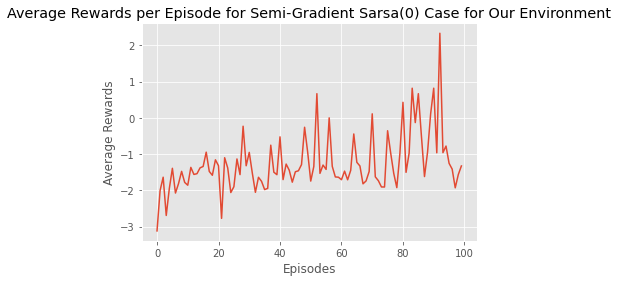

In [33]:
#For Semi-Gradient Sarsa(0)
step_size = 0.5  # Fraction of the way we want to move towards target
n = 1  # Level of bootstrapping, set to 1, since we go for Semi-Gradient Sarsa(0)
num_episodes = 100
estimator_n = QEstimator(step_size=step_size)

  
#To plot the Average rewards vs Episode graph for Semi-Gradient Sarsa(0)
avg_rew=[]
for i in range(num_episodes):
    episode_steps, episode_return = semi_grad_sarsa(n,env,estimator=estimator_n)
    tot_rew=episode_return
    average_reward=tot_rew/episode_steps
    avg_rew.append(average_reward)
    print("\rEpisode {}/{} Return {}".format(
            i + 1, num_episodes, episode_return), end="")
    #print(average_reward)
plt.plot(avg_rew)
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Rewards per Episode for Semi-Gradient Sarsa(0) Case for Our Environment')
plt.show()



Episode 1/100 Return -4.142056074766355
Episode 100/100 Return -0.47368421052631576

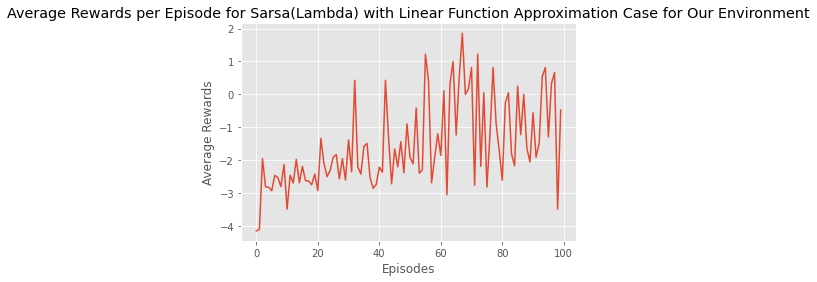

In [35]:
#For Sarsa(Lambda) with Linear Function Approximation
step_size = 0.5 # Fraction of the way we want to move towards target
lmbda = 0.90  # Level of bootstrapping, since its Sarsa(Lambda) with Linear Function Approximation and we keep lambda to 0.9
num_episodes = 100

estimator_lambda = QEstimator(step_size=step_size, trace=True)


#To plot the Average rewards vs Episode graph for Sarsa(Lambda) with Linear Function Approximation
avg_rew_sllfa=[]
for i in range(num_episodes):
    episode_steps, episode_return = sarsa_lambda_lfa(lmbda,env,estimator=estimator_lambda)
    tot_rew=episode_return
    average_reward=tot_rew/episode_steps
    avg_rew_sllfa.append(average_reward)
    print("\rEpisode {}/{} Return {}".format(
      1, num_episodes, average_reward), end="")
    #print(average_reward)
    print("\rEpisode {}/{} Return {}".format(
        i + 1, num_episodes, average_reward), end="")
plt.plot(avg_rew_sllfa)
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Rewards per Episode for Sarsa(Lambda) with Linear Function Approximation Case for Our Environment')
plt.show()